Merging DCT volumes
--

*Merging strategy:* look at overlapping region: determine center of mass for each grain restricted to this region (ie grain may be cut along Z). Find matching grains between the two sets of grains based on their respective orientation. Than find optimal rigid body transform between the two volumes. At this point the merging can be done in the following way: t5_dct_cen_ is taken as the reference (ids will not change within this volume). Additional volume are tranfsormed using the rigid body transformation found and merged. grains with a match in the reference volume are renumbered accordingly and other grains are renumbered consecutively to the last grain present. For each pixel in the overlapping region: if bothe pixel have the same label, it is preserved, it one pixel has a label and the other one is zero, the label is preserved. If both pixels are zero or non-zero, the voxel is set to zero.

3 scans: t5_dct_bot_, t5_dct_cen_, t5_dct_cen_1_, t5_dct_top_ 

samtz = -4.30922, -4.8095, -4.71812, -5.2102

In [1]:
delta = -4.30922 + 4.8095
print(delta)
print(delta / 0.0014)  # nb of slice offset

0.5002800000000001
357.3428571428572


In [14]:
from pymicro.crystal.microstructure import Microstructure, Orientation, Grain
from pymicro.crystal.lattice import Lattice, HklPlane, Symmetry
from pymicro.xray.experiment import Experiment
from pymicro.xray.detectors import RegArrayDetector2d
import numpy as np
import os

# create Experiment
exp = Experiment()
exp.get_sample().set_name('t5')
exp.get_sample().data_dir = os.path.join('id11', 't5_', 't5_dct_bot_')

Ti7Al = Lattice.hexagonal(0.2931, 0.4694)  # nm
print(Ti7Al.get_symmetry() is Symmetry.hexagonal)
exp.get_sample().set_material(Ti7Al)
exp.get_sample().set_microstructure(micro_bot)
exp.get_sample().grain_ids_path = os.path.join('5_reconstruction', 'volume_dilated.mat')
exp.get_source().set_energy(38.0)  # keV
lambda_keV = exp.get_source().max_energy

# DCT detector
u_dir = np.array([0.0044, 1.0, -6.0725e-04])
v_dir = np.array([0.0046, -6.2759e-04, -1.0])
w_dir = np.cross(u_dir, v_dir)
P_t5_ = np.array([u_dir, v_dir, w_dir]).T
detector = RegArrayDetector2d(size=(2048, 2048), P=P_t5_)
detector.pixel_size = 0.0014
detector.ref_pos = np.array([6.51, 0.0098, 0.0])
exp.add_detector(detector)

exp.save('%s_experiment.txt' % exp.get_sample().name)

True


In [15]:
# read microstructure for bot scan
rod_path = os.path.join(exp.get_sample().data_dir, '4_grains/phase_01/R_vectors.txt')
orientations = Orientation.read_orientations(rod_path, data_type='rodrigues', delimiter=',')
center_path = os.path.join(exp.get_sample().data_dir, '4_grains/phase_01/grain_centers.txt')
centers = np.genfromtxt(center_path, delimiter=',')
micro_bot = Microstructure(name='t5_dct_bot_')
for i in range(len(orientations)):
    gid = i + 1
    g = Grain(gid, orientations[gid])
    g.position = centers[i]
    g.center = centers[i]
    micro_bot.grains.append(g)
#micro = Microstructure.from_dct(data_root=exp.data_dir, grain_ids=[...])
print(micro_bot.get_grain(1))

Grain
 * id = 1
 * Crystal Orientation
orientation matrix = [[ 0.18167161  0.026714    0.98299633]
 [-0.4944908   0.86653136  0.06783995]
 [-0.84998487 -0.49840724  0.17063397]]
Euler angles (degrees) = ( 300.386,  80.175,  86.052)
Rodrigues vector = [ 0.2552 -0.8261  0.2349]
Quaternion = [ 0.74478805 -0.19006991  0.61526941  0.17495071]
 * position [ 0.0543  0.0573 -0.0404]
 * has vtk mesh ? False



In [6]:
import h5py
#grain_ids = exp.get_sample().get_grain_ids()
f = h5py.File('id11/t5_/t5_dct_bot_/5_reconstruction/phase_01_vol.mat')  #volume_dilated.mat')
print(f.keys())
#grain_ids_bot = f['grains'][:, 88:-88, 63:-63].transpose(2, 1, 0).astype(np.uint8)  # to have [x, y, z] representation
grain_ids_bot = f['vol'][:, 11:-11, 11:-11].transpose(2, 1, 0)  # to have [x, y, z] representation
print(grain_ids_bot.shape)
n = len(np.unique(grain_ids_bot))
f.close()
print('%d grains in the volume' % n)

<KeysViewHDF5 ['rotation_angles', 'rotation_axes', 'vol']>
(654, 654, 414)
165 grains in the volume


In [7]:
from pymicro.file.file_utils import HST_write
HST_write(grain_ids_bot[:, :, :], 't5_dct_bot_.raw')

opening t5_dct_bot_.raw for writing in mode w
volume size is 654x654x414
data type is int16
writing .info file
done with writing


In [16]:
# read microstructure for cen scan
cen_data_dir = os.path.join('id11', 't5_', 't5_dct_cen_')

rod_path = os.path.join(cen_data_dir, '4_grains/phase_01/R_vectors.txt')
orientations = Orientation.read_orientations(rod_path, data_type='rodrigues', delimiter=',')
center_path = os.path.join(cen_data_dir, '4_grains/phase_01/grain_centers.txt')
centers = np.genfromtxt(center_path, delimiter=',')
micro_cen = Microstructure(name='t5_dct_cen_')
for i in range(len(orientations)):
    gid = i + 1
    g = Grain(gid, orientations[gid])
    g.position = centers[i]
    g.center = centers[i]
    micro_cen.grains.append(g)
#micro = Microstructure.from_dct(data_root=exp.data_dir, grain_ids=[...])
print(micro_cen.get_grain(1))



Grain
 * id = 1
 * Crystal Orientation
orientation matrix = [[ 0.60920595 -0.23564272 -0.75719259]
 [ 0.37331398  0.92763167  0.0116687 ]
 [ 0.69964619 -0.28977922  0.65308745]]
Euler angles (degrees) = (  67.502,  49.225, 270.883)
Rodrigues vector = [ 0.0945  0.4567 -0.1909]
Quaternion = [ 0.89301807 -0.08439021  0.40784135  0.17047715]
 * position [ 0.0644 -0.1433 -0.121 ]
 * has vtk mesh ? False



In [17]:
f = h5py.File('id11/t5_/t5_dct_cen_/5_reconstruction/phase_01_vol.mat') #volume_dilated.mat')
print(f.keys())
#grain_ids_cen = f['grains'][:, 77:-77, 52:-52].transpose(2, 1, 0).astype(np.uint8)  # to have [x, y, z] representation
grain_ids_cen = f['vol'][()].transpose(2, 1, 0)
print(grain_ids_cen.dtype)
print(grain_ids_cen.shape)
n = len(np.unique(grain_ids_cen))
f.close()
print('%d grains in the volume' % n)

<KeysViewHDF5 ['rotation_angles', 'rotation_axes', 'vol']>
int16
(654, 654, 420)
146 grains in the volume


In [10]:
from pymicro.file.file_utils import HST_write
HST_write(grain_ids_cen[:, :, :], 't5_dct_cen_.raw')

opening t5_dct_cen_.raw for writing in mode w
volume size is 654x654x420
data type is int16
writing .info file
done with writing


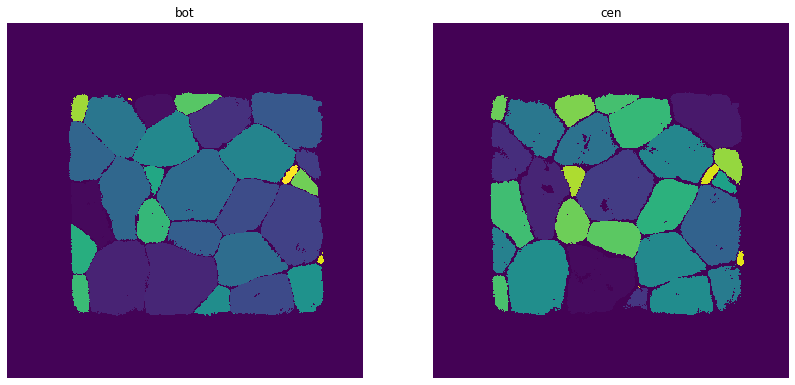

In [11]:
from matplotlib import pyplot as plt, cm
%matplotlib inline

fig = plt.figure(figsize=(14, 7))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(grain_ids_bot[:, :, 366].T)
plt.axis('off')
plt.title('bot')
ax1 = fig.add_subplot(1, 2, 2)
ax1.imshow(grain_ids_cen[:, :, 0].T)
plt.axis('off')
plt.title('cen')
plt.show()

In [12]:
from scipy import ndimage
voxel_size = 0.0014

# we need to determine approximately the overlap region (based on the difference in samtz)

# create two microstructure of the overlapping regions: slices 364-413 in scan bot and slices 0-49 in scan cen
grain_ids_bot_ol = grain_ids_bot[:, :, 364:]
grain_ids_cen_ol = grain_ids_cen[:, :, :50]
dims_bot = np.array(grain_ids_bot_ol.shape)
print(dims_bot)
dims_cen = np.array(grain_ids_cen_ol.shape)
print(dims_cen)

[654 654  50]
[654 654  50]


In [18]:
ids_cen_ol = np.unique(grain_ids_cen_ol)[2:]  # skip -1 and 0
print(ids_cen_ol)

# difference due to the crop
offset = voxel_size * 0.5 * (np.array(grain_ids_cen_ol.shape) - np.array(grain_ids_cen.shape))

# read microstructure for bot scan
micro_cen_ol = Microstructure(name='t5_dct_cen_ol_')
for gid in ids_cen_ol:
    if gid == -1:
        continue
    g = Grain(gid, micro_cen.get_grain(gid).orientation)
    # recalculate position as we look at a truncated volume
    array_bin = (grain_ids_cen_ol == gid).astype(np.uint8)
    local_com = ndimage.measurements.center_of_mass(array_bin, grain_ids_cen_ol)
    com_mm = voxel_size * (local_com - 0.5 * np.array(grain_ids_cen_ol.shape)) + offset
    print('grain %2d position: %6.3f, %6.3f, %6.3f' % (gid, com_mm[0], com_mm[1], com_mm[2]))
    g.position = com_mm
    g.center = com_mm
    micro_cen_ol.grains.append(g)

[  1   3   5   6   9  10  14  16  17  18  22  25  32  40  45  51  52  54
  57  60  63  66  68  70  71  82  90  93  97 100 102 103 105 108 110 112
 113 117 118 122 127 129 134 135 137 138 139 145]
grain  1 position:  0.076, -0.163, -0.242
grain  3 position: -0.067,  0.187, -0.254
grain  5 position: -0.147, -0.121, -0.230
grain  6 position:  0.158,  0.057, -0.244
grain  9 position:  0.249, -0.206, -0.258
grain 10 position:  0.256, -0.049, -0.233
grain 14 position: -0.175,  0.010, -0.257
grain 16 position: -0.257,  0.272, -0.233
grain 17 position: -0.239, -0.249, -0.228
grain 18 position: -0.265, -0.101, -0.256
grain 22 position:  0.098,  0.244, -0.250
grain 25 position:  0.012, -0.018, -0.260
grain 32 position:  0.228,  0.238, -0.235
grain 40 position:  0.265, -0.119, -0.226
grain 45 position:  0.268,  0.072, -0.264
grain 51 position: -0.073, -0.245, -0.241
grain 52 position: -0.296,  0.192, -0.239
grain 54 position: -0.064, -0.149, -0.263
grain 57 position: -0.192, -0.193, -0.262
grain 

In [19]:
ids_bot_ol = np.unique(grain_ids_bot_ol)[2:]  # skip -1 and 0
print(ids_bot_ol)

# difference due to the crop
offset = voxel_size * 0.5 * (np.array(grain_ids_bot.shape) - np.array(grain_ids_bot_ol.shape))

# read microstructure for bot scan
micro_bot_ol = Microstructure(name='t5_dct_bot_ol_')
for gid in ids_bot_ol:
    if gid == -1:
        continue
    g = Grain(gid, micro_bot.get_grain(gid).orientation)
    # recalculate position as we look at a truncated volume
    array_bin = (grain_ids_bot_ol == gid).astype(np.uint8)
    local_com = ndimage.measurements.center_of_mass(array_bin, grain_ids_bot_ol)
    com_mm = voxel_size * (local_com - 0.5 * np.array(grain_ids_bot_ol.shape)) + offset
    print('grain %2d position: %6.3f, %6.3f, %6.3f' % (gid, com_mm[0], com_mm[1], com_mm[2]))
    g.position = com_mm
    g.center = com_mm
    micro_bot_ol.grains.append(g)

[  2   4  11  12  16  21  22  26  27  32  35  38  39  41  42  46  53  55
  58  60  64  71  74  77  79  81  88  93 102 111 114 118 119 124 128 129
 130 133 135 137 143 147 148 154 155 161 164]
grain  2 position: -0.251,  0.030,  0.229
grain  4 position: -0.077, -0.239,  0.228
grain 11 position: -0.179,  0.208,  0.235
grain 12 position: -0.050,  0.189,  0.259
grain 16 position:  0.092, -0.204,  0.230
grain 21 position:  0.318, -0.098,  0.226
grain 22 position:  0.283,  0.070,  0.249
grain 26 position:  0.204,  0.247,  0.244
grain 27 position:  0.161,  0.010,  0.233
grain 32 position:  0.266, -0.206,  0.255
grain 35 position:  0.031,  0.092,  0.229
grain 38 position: -0.252, -0.103,  0.257
grain 39 position: -0.160,  0.010,  0.257
grain 41 position:  0.029, -0.021,  0.254
grain 42 position:  0.163,  0.153,  0.242
grain 46 position: -0.176, -0.196,  0.251
grain 53 position:  0.194, -0.112,  0.245
grain 55 position: -0.048, -0.150,  0.251
grain 58 position:  0.108,  0.249,  0.262
grain 60 p

In [20]:
print(len(micro_bot_ol.grains))
print(len(micro_cen_ol.grains))

47
48


In [21]:
def match_grains(micro1, micro2, use_grain_ids=None, verbose=False):
    mis_tol = 1  # degrees
    candidates = []
    matched = []  # np.zeros(len(micro1.grains), dtype=int)
    unmatched = []  # grain that were not matched within the given tolerance
    # restrict the grain ids to match if needed
    if use_grain_ids:
        grains_to_match = [micro1.get_grain(gid) for gid in use_grain_ids]
    else:
        grains_to_match = micro1.grains
    # look at each grain
    for i, g1 in enumerate(grains_to_match):
        cands_for_g1 = []
        best_mis = mis_tol
        best_match = -1
        for g2 in micro2.grains:
            # compute disorientation
            mis, _, _ = g1.orientation.disorientation(g2.orientation, crystal_structure=Ti7Al.get_symmetry())
            misd = np.degrees(mis)
            if misd < mis_tol:
                if verbose:
                    print('grain %3d -- candidate: %3d, misorientation: %.2f deg' % (g1.id, g2.id, misd))
                # add this grain to the list of candidates
                cands_for_g1.append(g2.id)
                if misd < best_mis:
                    best_mis = misd
                    best_match = g2.id
        # add our best match or mark this grain as unmatched
        if best_match > 0:
            matched.append([g1.id, best_match])
        else:
            unmatched.append(g1.id)
        candidates.append(cands_for_g1)
    if verbose:
        print('done with matching')
        print('%d/%d grains were matched '% (len(matched), len(grains_to_match)))
    return matched, candidates, unmatched

In [22]:
# micro_cen_ is the reference
matched, _, unmatched = match_grains(micro_cen_ol, micro_bot_ol, verbose=True)

grain   1 -- candidate:  64, misorientation: 0.04 deg
grain   3 -- candidate:  12, misorientation: 0.03 deg
grain   5 -- candidate: 143, misorientation: 0.06 deg
grain   6 -- candidate:  77, misorientation: 0.04 deg
grain   9 -- candidate:  32, misorientation: 0.07 deg
grain  10 -- candidate: 133, misorientation: 0.04 deg
grain  14 -- candidate:  39, misorientation: 0.03 deg
grain  16 -- candidate: 135, misorientation: 0.09 deg
grain  17 -- candidate: 137, misorientation: 0.09 deg
grain  18 -- candidate:  38, misorientation: 0.01 deg
grain  22 -- candidate:  58, misorientation: 0.03 deg
grain  25 -- candidate:  41, misorientation: 0.06 deg
grain  32 -- candidate: 124, misorientation: 0.03 deg
grain  40 -- candidate: 154, misorientation: 0.06 deg
grain  45 -- candidate:  22, misorientation: 0.04 deg
grain  51 -- candidate: 118, misorientation: 0.03 deg
grain  52 -- candidate: 130, misorientation: 0.04 deg
grain  54 -- candidate:  55, misorientation: 0.01 deg
grain  57 -- candidate:  46,

In [23]:
print(matched)
print(micro_cen_ol.grains[0].center)
print(micro_bot_ol.get_grain(matched[0][1]).center)

[[1, 64], [3, 12], [5, 143], [6, 77], [9, 32], [10, 133], [14, 39], [16, 135], [17, 137], [18, 38], [22, 58], [25, 41], [32, 124], [40, 154], [45, 22], [51, 118], [52, 130], [54, 55], [57, 46], [60, 60], [63, 74], [66, 53], [68, 42], [70, 26], [71, 11], [82, 93], [90, 128], [93, 27], [97, 16], [100, 2], [102, 88], [103, 81], [105, 111], [108, 35], [110, 148], [112, 102], [113, 79], [117, 4], [118, 129], [122, 21], [127, 71], [129, 164], [134, 161], [135, 147], [137, 119], [138, 155], [139, 114]]
[ 0.07589662 -0.16309929 -0.24170172]
[ 0.09158459 -0.16452862  0.27229732]


In [24]:
unmatched

[145]

In [25]:
from pymicro.view.vol_utils import compute_affine_transform

# compute the affine transform
n_points = 47 # markers per image
fixed = np.zeros((n_points, 3))
moving = np.zeros((n_points, 3))
moved = np.zeros_like(moving)

# markers in t5_dct_bot_ol_
for i in range(n_points):
    fixed[i] = micro_cen_ol.grains[i].center
    moving[i] = micro_bot_ol.get_grain(matched[i][1]).center

# call the registration method
translation, transformation = compute_affine_transform(fixed, moving)
invt = np.linalg.inv(transformation)

# check what are now the points after transformation
fixed_centroid = np.average(fixed, axis=0)
moving_centroid = np.average(moving, axis=0)
print('fixed centroid: {}'.format(fixed_centroid))
print('moving centroid: {}'.format(moving_centroid))

for j in range(n_points):
  moved[j] = fixed_centroid + np.dot(transformation, moving[j] - moving_centroid)
  print('point %d will move to (%6.3f, %6.3f, %6.3f) to be compared with (%6.3f, %6.3f, %6.3f)' % (j, moved[j, 0], moved[j, 1], moved[j, 2], fixed[j, 0], fixed[j, 1], fixed[j, 2]))
print('transformation is:')
print(invt)

# offset and translation, here we only look for rigid body translation
offset = -np.dot(invt, translation)
print(translation, offset)
translation_voxel = (translation / voxel_size).astype(int)
print(translation_voxel)

fixed centroid: [ 0.04357813 -0.00323079 -0.25856733]
moving centroid: [ 0.05933486 -0.00364127  0.2555615 ]
point 0 will move to ( 0.076, -0.163, -0.242) to be compared with ( 0.076, -0.163, -0.242)
point 1 will move to (-0.066,  0.189, -0.255) to be compared with (-0.067,  0.187, -0.254)
point 2 will move to (-0.147, -0.120, -0.230) to be compared with (-0.147, -0.121, -0.230)
point 3 will move to ( 0.159,  0.054, -0.243) to be compared with ( 0.158,  0.057, -0.244)
point 4 will move to ( 0.250, -0.205, -0.259) to be compared with ( 0.249, -0.206, -0.258)
point 5 will move to ( 0.255, -0.049, -0.233) to be compared with ( 0.256, -0.049, -0.233)
point 6 will move to (-0.175,  0.010, -0.257) to be compared with (-0.175,  0.010, -0.257)
point 7 will move to (-0.256,  0.275, -0.234) to be compared with (-0.257,  0.272, -0.233)
point 8 will move to (-0.249, -0.253, -0.231) to be compared with (-0.239, -0.249, -0.228)
point 9 will move to (-0.267, -0.102, -0.257) to be compared with (-0.26

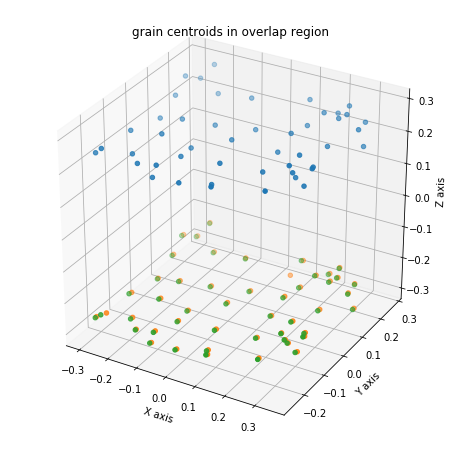

In [26]:
from mpl_toolkits import mplot3d

# plot the grain centroids in 3D
fig = plt.figure(figsize=(8, 8))
ax = plt.axes(projection='3d')
# plot grain centroids in micro_bot_ol
g_center_x = [g.center[0] for g in micro_bot_ol.grains] 
g_center_y = [g.center[1] for g in micro_bot_ol.grains] 
g_center_z = [g.center[2] for g in micro_bot_ol.grains] 
ax.scatter3D(g_center_x, g_center_y, g_center_z)
# plot grain centroids in micro_cen_ol
g_center_x = [g.center[0] for g in micro_cen_ol.grains] 
g_center_y = [g.center[1] for g in micro_cen_ol.grains] 
g_center_z = [g.center[2] for g in micro_cen_ol.grains] 
ax.scatter3D(g_center_x, g_center_y, g_center_z)
# now plot moved grain centroids
g_center_x = [g.center[0] + translation[0] for g in micro_bot_ol.grains] 
g_center_y = [g.center[1] + translation[1] for g in micro_bot_ol.grains] 
g_center_z = [g.center[2] + translation[2] for g in micro_bot_ol.grains] 
ax.scatter3D(g_center_x, g_center_y, g_center_z)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
plt.title('grain centroids in overlap region')
plt.show()

In [28]:
# prepare a volume with ids changed (should be the entire volume)
grain_ids_bot_ol_matched = np.zeros_like(grain_ids_bot_ol)
for match in matched:
    cen_id, bot_id = match
    grain_ids_bot_ol_matched[grain_ids_bot_ol == bot_id] = cen_id
print(grain_ids_bot_ol_matched.shape)

(654, 654, 50)


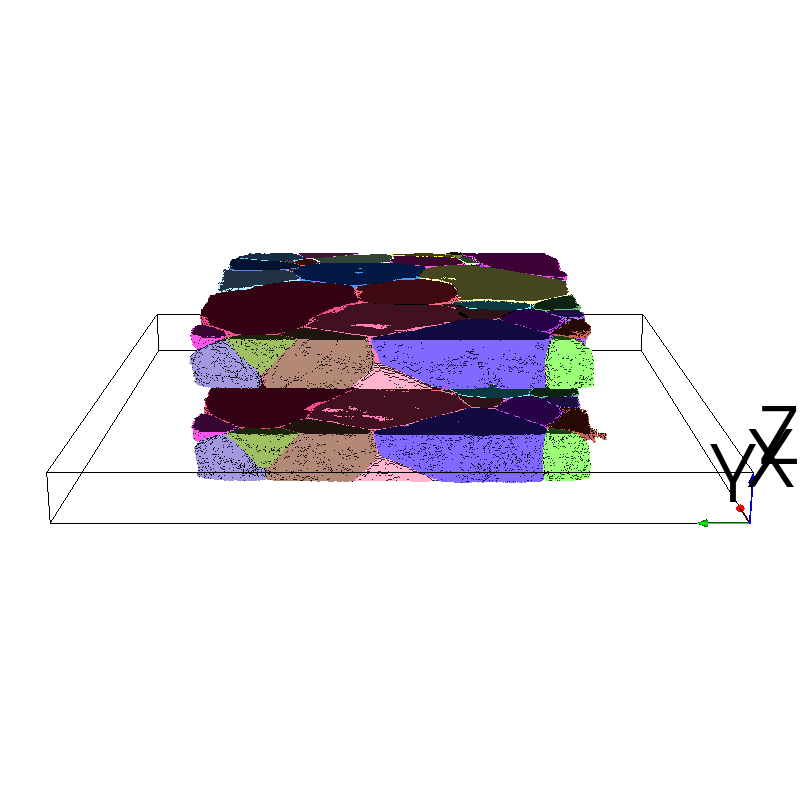

In [29]:
from pymicro.view.vtk_utils import *
from pymicro.view.scene3d import Scene3D
from IPython.display import Image

dims = np.array(grain_ids_bot_ol_matched.shape)
# show only grains imaged with TT
grains_bot_ol = show_grains(grain_ids_bot_ol_matched)
grains_cen_ol = show_grains(grain_ids_cen_ol)
apply_translation_to_actor(grains_cen_ol, (0, 0, 100))
box = box_3d(size=dims_bot)
axes = axes_actor(100, axisLabels=('X', 'Y', 'Z'), fontSize=50)
s3d = Scene3D(display=False, ren_size=(800, 800), name='t5_dct_bot-cen_ol_3d')
s3d.add(grains_bot_ol)
s3d.add(grains_cen_ol)
s3d.add(box)
s3d.add(axes)
cam = setup_camera(size=dims)
cam.SetFocalPoint(0.5 * dims)
cam.SetViewUp(0, 0, 1)
cam.SetPosition(-2 * dims[0], 0.5 * dims[0], 10 * dims[2])
s3d.set_camera(cam)
im = s3d.get_frame()
Image(im)

In [34]:
ids_cen = np.unique(grain_ids_cen)
ids_cen_list = ids_cen.tolist()
ids_cen_list.remove(-1)  # grain overlap
ids_cen_list.remove(0)  # beckground
print(ids_cen_list)
id_offset = max(ids_cen_list)
print('grain ids in volume grain_ids_bot will be offset by %d' % id_offset)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 144, 145, 146]
grain ids in volume grain_ids_bot will be offset by 146


prepare a volume with the same size as grain_ids_bot, with grain ids renumbered and (X, Y) translations applied. 

In [31]:
grain_ids_bot_translated = grain_ids_bot.copy()
print('renumbering grains in the overlap region')
for match in matched:
    cen_id, bot_id = match
    print('replacing %d by %d' % (bot_id, cen_id))
    grain_ids_bot_translated[grain_ids_bot == bot_id] = cen_id
print(grain_ids_bot_ol_matched.shape)
# TODO also renumber the rest

renumbering grains in the overlap region
replacing 64 by 1
replacing 12 by 3
replacing 143 by 5
replacing 77 by 6
replacing 32 by 9
replacing 133 by 10
replacing 39 by 14
replacing 135 by 16
replacing 137 by 17
replacing 38 by 18
replacing 58 by 22
replacing 41 by 25
replacing 124 by 32
replacing 154 by 40
replacing 22 by 45
replacing 118 by 51
replacing 130 by 52
replacing 55 by 54
replacing 46 by 57
replacing 60 by 60
replacing 74 by 63
replacing 53 by 66
replacing 42 by 68
replacing 26 by 70
replacing 11 by 71
replacing 93 by 82
replacing 128 by 90
replacing 27 by 93
replacing 16 by 97
replacing 2 by 100
replacing 88 by 102
replacing 81 by 103
replacing 111 by 105
replacing 35 by 108
replacing 148 by 110
replacing 102 by 112
replacing 79 by 113
replacing 4 by 117
replacing 129 by 118
replacing 21 by 122
replacing 71 by 127
replacing 164 by 129
replacing 161 by 134
replacing 147 by 135
replacing 119 by 137
replacing 155 by 138
replacing 114 by 139
(654, 654, 50)


In [35]:
# apply translation along the (X, Y) axes
grain_ids_bot_translated = np.roll(grain_ids_bot_translated, (-12, -3), (0, 1))

47
392


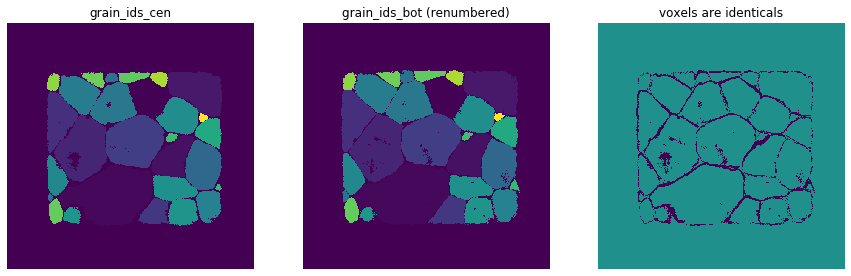

In [47]:
check = 25
print(overlap)
print(-translation_voxel[2] + check)
fig = plt.figure(figsize=(15, 7))
ax1 = fig.add_subplot(1, 3, 1)
ax1.imshow(grain_ids_cen[:, :, check].T, vmin=0)
plt.axis('off')
plt.title('grain_ids_cen')
ax2 = fig.add_subplot(1, 3, 2)
ax2.imshow(grain_ids_bot_translated[:, :, -translation_voxel[2] + check].T, vmin=0)
plt.axis('off')
plt.title('grain_ids_bot (renumbered)')
ax3 = fig.add_subplot(1, 3, 3)
same = grain_ids_cen[:, :, check] == grain_ids_bot_translated[:, :, -translation_voxel[2] + check]
ax3.imshow(same.T, vmin=0, vmax=2)
plt.axis('off')
plt.title('voxels are identicals')
plt.show()

In [36]:
367 + 47 + 373

787

overlap is 47 voxels
vertical size will be: 367 + 47 + 373 = 787
initializing volume with shape [654 654 787]
(654, 654, 420)
(654, 654, 414)
(654, 654, 47)
(654, 654, 47)
(654, 654, 47)


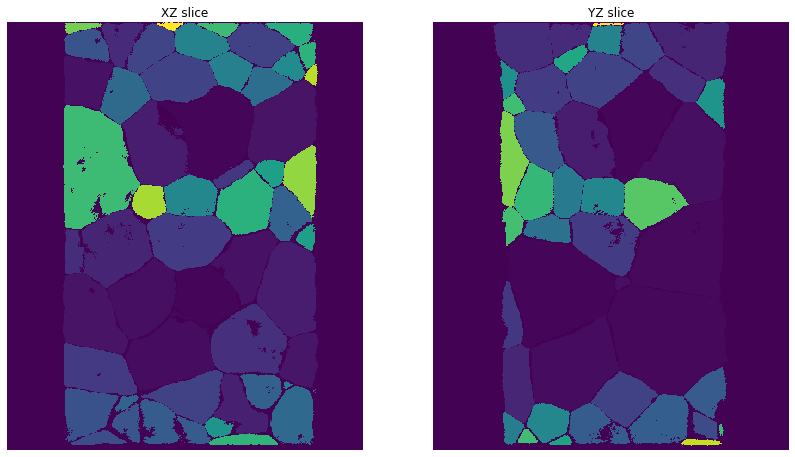

In [50]:
# start the merging: _cen_ volume is the reference, translation is (-12, -3, -367)
overlap = grain_ids_bot.shape[2] + translation_voxel[2]
print('overlap is %d voxels' % overlap)
z_shape = grain_ids_bot.shape[2] + grain_ids_cen.shape[2] - overlap
print('vertical size will be: %d + %d + %d = %d' % (grain_ids_bot.shape[2] - overlap, overlap, grain_ids_cen.shape[2] - overlap, z_shape))
shape_merged = np.array(grain_ids_cen.shape) + [0, 0, grain_ids_bot.shape[2] - overlap]
print('initializing volume with shape {}'.format(shape_merged))
grain_ids_merged = np.zeros(shape_merged, dtype=np.int16)
print(grain_ids_cen.shape)
print(grain_ids_bot.shape)
# add the non-overlapping part of the 2 volumes as is
grain_ids_merged[:, :, :grain_ids_bot.shape[2] - overlap] = grain_ids_bot_translated[:, :, :-overlap]
grain_ids_merged[:, :, grain_ids_bot.shape[2]:] = grain_ids_cen[:, :, overlap:]
# look at vertices with the same label 
same_voxel = grain_ids_cen[:, :, :overlap] == grain_ids_bot_translated[:, :, -translation_voxel[2]:-translation_voxel[2]+overlap]
print(same_voxel.shape)
print(grain_ids_merged[:, :, grain_ids_bot.shape[2] - overlap:grain_ids_bot.shape[2]].shape)
print(grain_ids_cen[:, :, :overlap].shape)
grain_ids_merged[:, :, grain_ids_bot.shape[2] - overlap:grain_ids_bot.shape[2]] = grain_ids_cen[:, :, :overlap] * same_voxel

fig = plt.figure(figsize=(14, 10))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(grain_ids_merged[:, 320, :].T)
plt.axis('off')
plt.title('XZ slice')
ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(grain_ids_merged[320, :, :].T)
plt.axis('off')
plt.title('YZ slice')
plt.show()

In [52]:
# write the concanetated volume
from pymicro.file.file_utils import HST_write
HST_write(grain_ids_merged, 't5_test_cat.raw')

opening t5_test_cat.raw for writing in mode w
volume size is 654x654x787
data type is int16
writing .info file
done with writing
